# 파일 로드

petfinder/</br>
ﾠﾠﾠﾠﾠsamplesubmission.csv</br>
ﾠﾠﾠﾠﾠtrian.csv</br>
ﾠﾠﾠﾠﾠtest.csv</br>
ﾠﾠﾠﾠﾠtrain/</br>
ﾠﾠﾠﾠﾠtest/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import cv2

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

In [5]:
path = '/gdrive/My Drive/data/petfinder/'

In [6]:
train = pd.read_csv(path + 'train.csv',index_col='Id')
test = pd.read_csv(path +  'test.csv',index_col='Id')
submission = pd.read_csv(path + 'sample_submission.csv')

train.shape, test.shape, submission.shape

((9912, 13), (8, 12), (8, 2))

In [7]:
from glob import glob

In [8]:
display(train.head(2))
display(test.head(2))

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
Id,,,,,,,,,,,,,
0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
Id,,,,,,,,,,,,
4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0


# 시각화

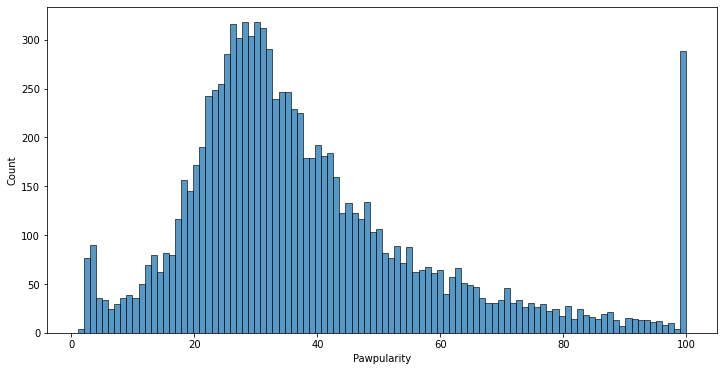

In [9]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x='Pawpularity', bins=100)

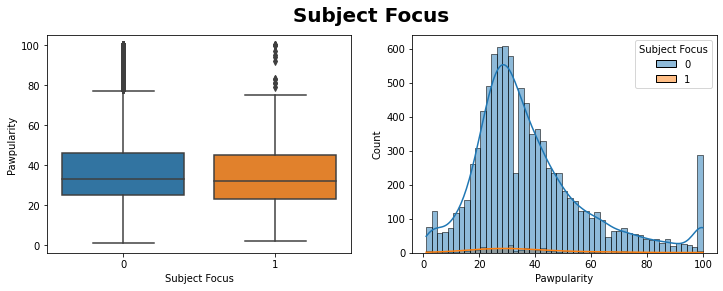

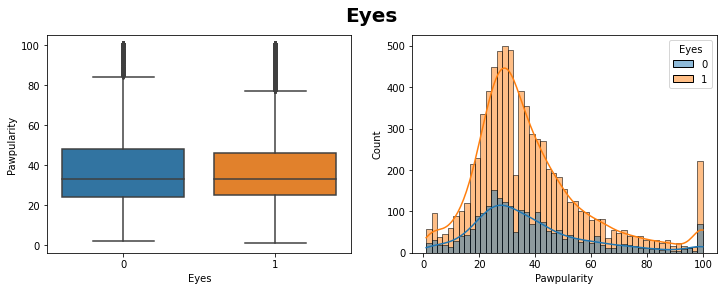

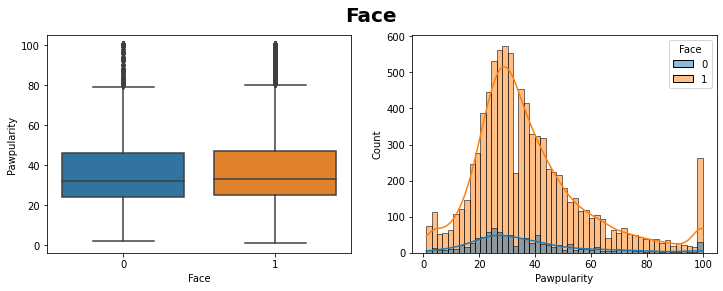

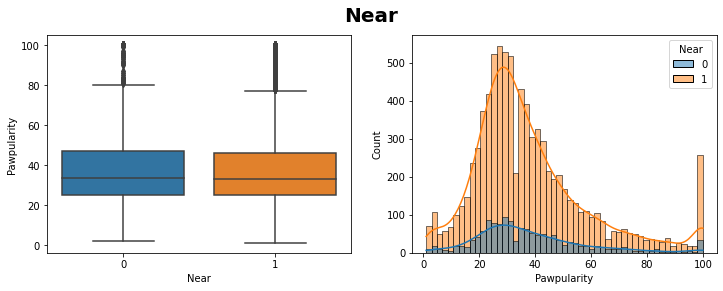

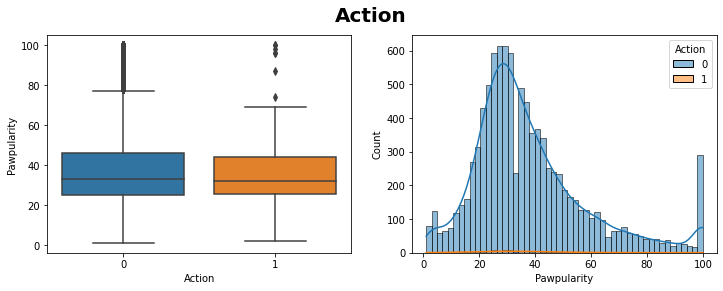

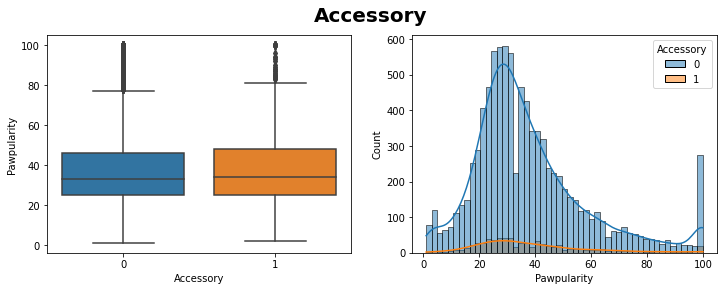

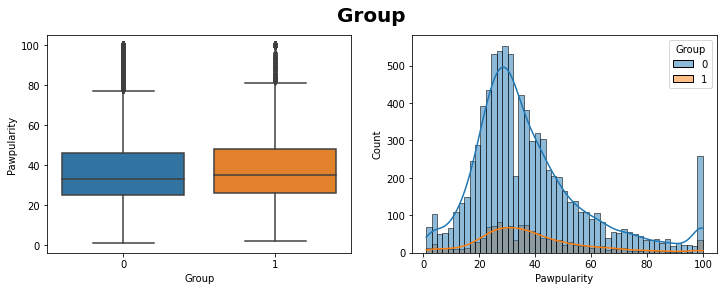

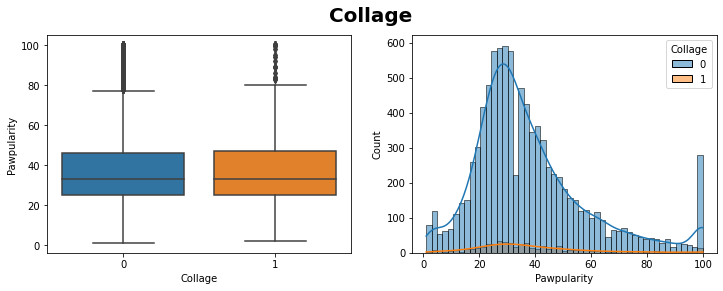

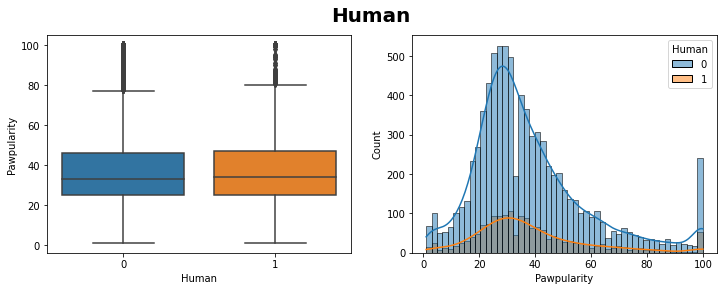

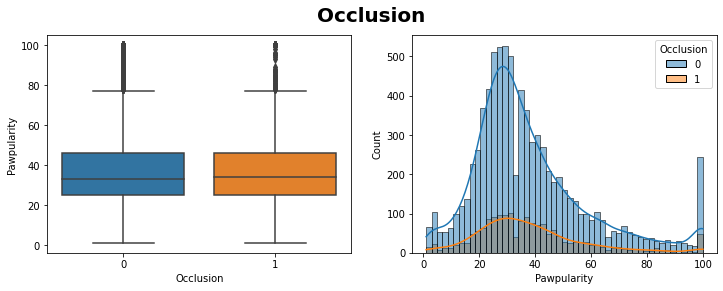

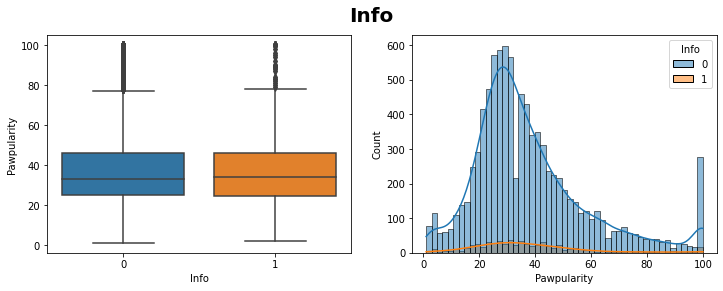

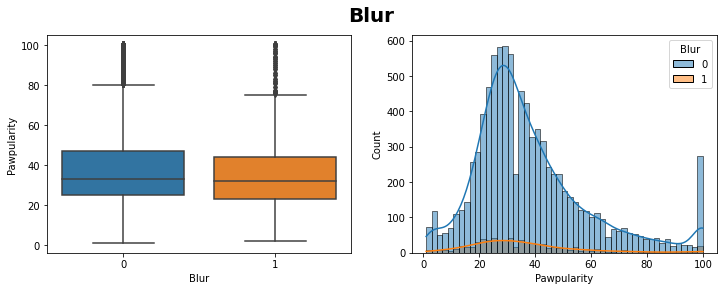

In [10]:
for i in test.columns:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.boxplot(data=train, x=i, y='Pawpularity', ax=ax[0])
    sns.histplot(train, x="Pawpularity", hue=i, kde=True, ax=ax[1])
    plt.suptitle(i, fontsize=20, fontweight='bold')
    fig.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)

In [12]:
batch_size = 32
height = 180
width = 180

In [13]:
import tensorflow as tf

train_path = path + 'train'
train.loc[:, 'filename'] = train.index + '.jpg'

train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_path, 
    x_col='filename',
    y_col='Pawpularity',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='raw',
    subset="training",
    target_size=(height, width)
)

Found 7930 validated image filenames.


In [14]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_path, 
    x_col='filename',
    y_col='Pawpularity',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='raw',
    subset="validation",
    target_size=(height, width)
)

Found 1982 validated image filenames.


In [15]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model = Sequential([
  layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(height,width,3)),
  layers.MaxPooling2D(),

  layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(units=128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1, activation='linear')
])

In [16]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [19]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop],
)

Epoch 1/10
248/248 [==============================] - 2811s 11s/step - loss: 483.4635 - rmse: 21.9878 - val_loss: 448.0667 - val_rmse: 21.1676
Epoch 2/10
248/248 [==============================] - 115s 465ms/step - loss: 455.0193 - rmse: 21.3312 - val_loss: 440.3379 - val_rmse: 20.9842
Epoch 3/10
248/248 [==============================] - 113s 455ms/step - loss: 439.8731 - rmse: 20.9732 - val_loss: 433.4541 - val_rmse: 20.8196
Epoch 4/10
248/248 [==============================] - 113s 455ms/step - loss: 432.4826 - rmse: 20.7962 - val_loss: 429.7085 - val_rmse: 20.7294
Epoch 5/10
248/248 [==============================] - 113s 456ms/step - loss: 429.9158 - rmse: 20.7344 - val_loss: 427.8791 - val_rmse: 20.6852
Epoch 6/10
248/248 [==============================] - 111s 450ms/step - loss: 424.2744 - rmse: 20.5979 - val_loss: 436.1127 - val_rmse: 20.8833
Epoch 7/10
248/248 [==============================] - 113s 454ms/step - loss: 414.8817 - rmse: 20.3686 - val_loss: 463.1870 - val_rmse: 2

In [20]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,rmse,val_loss,val_rmse
5,424.274445,20.597923,436.112732,20.883312
6,414.881744,20.368647,463.186981,21.521778
7,394.865082,19.871212,451.084045,21.238739
8,379.509827,19.481012,469.656769,21.671566
9,349.719452,18.700787,502.700714,22.420988


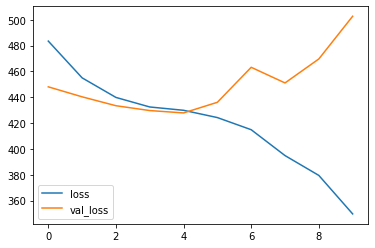

In [21]:
df_hist[['loss', 'val_loss']].plot()

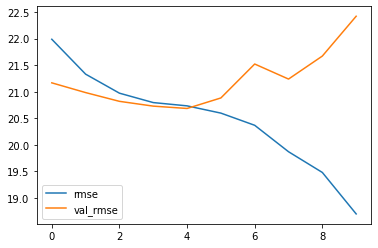

In [22]:
df_hist[['rmse', 'val_rmse']].plot()

In [ ]:
# 오버피팅

In [23]:
model.evaluate(valid_generator)

62/62 [==============================] - 22s 358ms/step - loss: 502.7007 - rmse: 22.4210


[502.7006530761719, 22.42098617553711]

In [24]:
test_path = path + 'test'
test.loc[:, 'filename'] = test.index + '.jpg'

test_generator = datagen.flow_from_dataframe(dataframe=test,
                                             directory=test_path, 
                                             x_col='filename',
                                             y_col=None,
                                             batch_size=batch_size,
                                             seed=42,
                                             shuffle=False,
                                             class_mode=None,
                                             target_size=(height, width)
                                            )

Found 8 validated image filenames.


In [25]:
y_test = model.predict(test_generator, verbose=1)

1/1 [==============================] - 0s 216ms/step


In [26]:
submission = pd.DataFrame()
submission['Id'] = test.index
submission['Pawpularity'] = y_test * 100
submission.to_csv('submission.csv',index = False)

In [27]:
pd.read_csv('submission.csv').head(2)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,3753.020
1,43a2262d7738e3d420d453815151079e,3815.724
